In [1]:
import numpy as np
import lbg_forecast.nz as nz
import lbg_forecast.population_model as pop
import lbg_forecast.nz as nz
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import lbg_forecast.priors_gp_dust as gpdp
import scipy as sc

In [3]:
nruns=1
run='test_0'
colours=True
spsp = []
photometry = []
nzs = []
trans = []
for i in range(nruns):
    spsp.append(np.load("sps_parameter_samples/sps_"+run+"_"+str(i)+".npy"))
    photometry.append(np.load("photo_samples/photo_"+run+"_"+str(i)+".npy"))
    nzs.append(np.load("nz_samples/nz_"+run+"_"+str(i)+".npy", allow_pickle=True))
    trans.append(np.load("nz_samples/trans_"+run+"_"+str(i)+".npy"))

spsp = np.vstack(spsp)
photometry = np.vstack(photometry)
nzs = np.vstack(nzs)
trans = np.vstack(trans)
print(spsp.shape, photometry.shape, nzs.shape, trans.shape)

(16, 4000000, 17) (16, 4000000, 5) (16, 3) (16, 3)


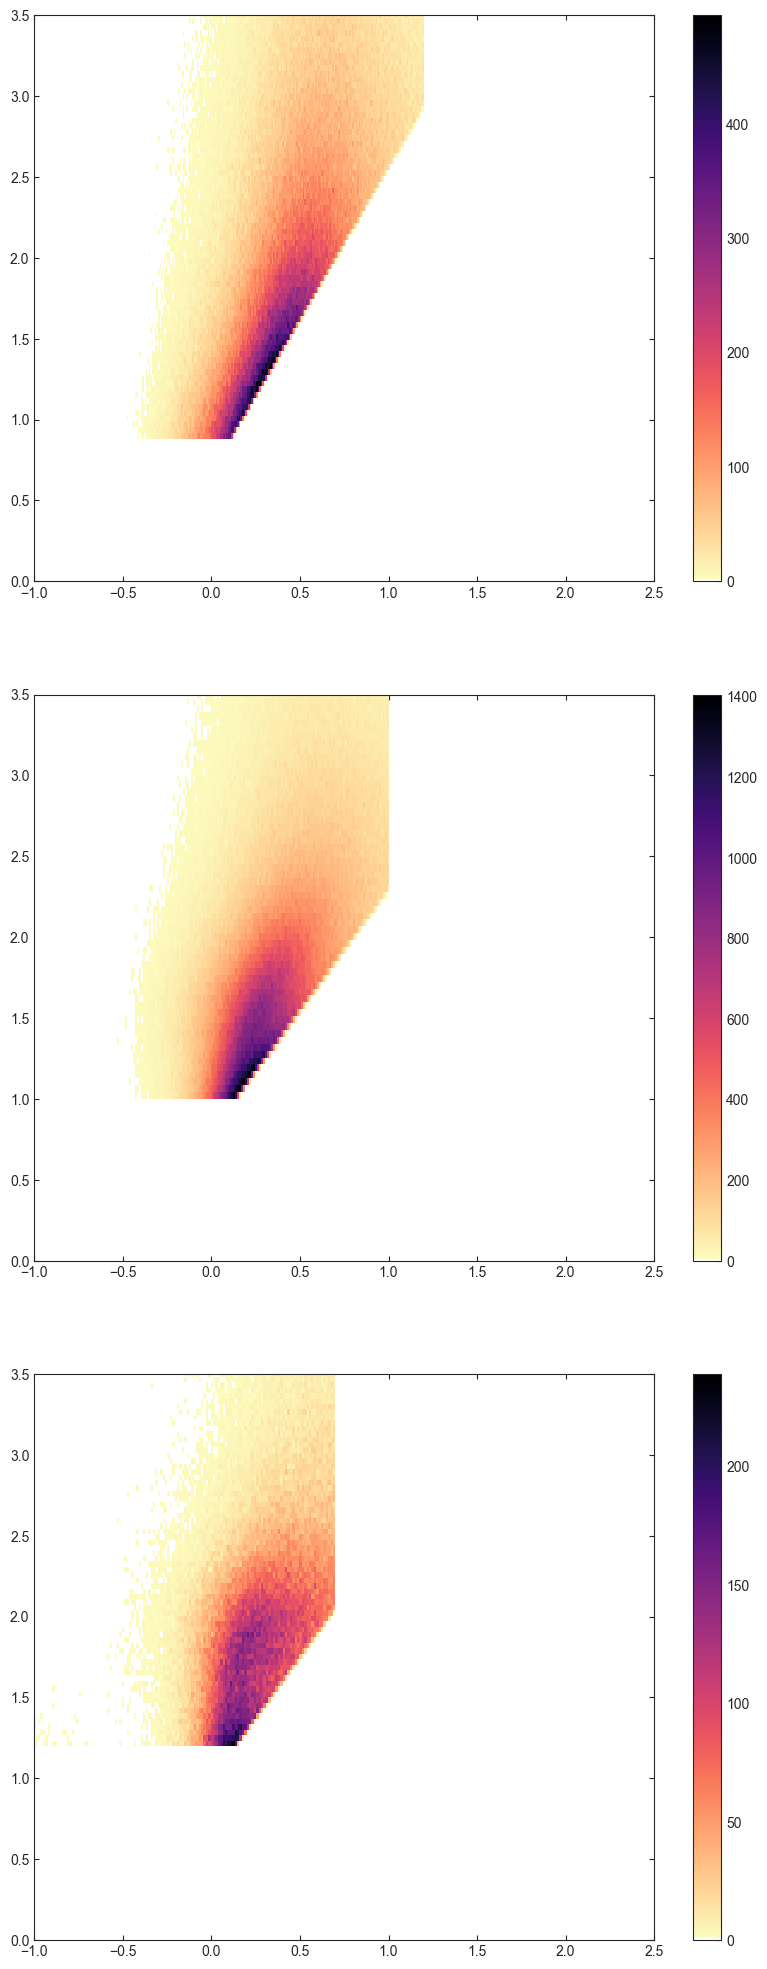

In [3]:
run_no=0
if(colours):

    from matplotlib.colors import LinearSegmentedColormap
    magma = plt.get_cmap('magma_r')
    rgba = magma(np.linspace(0, 1, 256))
    rgba[0] = [1, 1, 1, 1]
    magma_whitebackground = LinearSegmentedColormap.from_list('magma_white', rgba)

    f, ax = plt.subplots(3, 1, figsize=(10, 25))
    lbg_colours = np.load("nz_samples/c_"+run+"_"+str(run_no)+".npy", allow_pickle=True)
    for i in range(3):
        cs = []
        for real in lbg_colours[:, i]:
            cs.append(np.squeeze(real))

        dropout_colours = np.vstack(cs)
        histogram = ax[i].hist2d(dropout_colours[:, i+1], dropout_colours[:, i], alpha=1.0, bins=(200,400), cmap=magma_whitebackground, density=False)
        f.colorbar(histogram[-1], orientation='vertical')
        ax[i].set_ylim(0, 3.5)
        ax[i].set_xlim(-1, 2.5)


In [4]:
print(photometry.shape, nzs.shape)
ntot = photometry.shape[1]
ntot_background = 2582112#717
utrans = []
gtrans = []
rtrans = []
for i in range(photometry.shape[0]):
    utrans.append(len(nzs[i, 0])/ntot)
    gtrans.append(len(nzs[i, 1])/ntot)
    rtrans.append(len(nzs[i, 2])/ntot)

utrans_mean = np.mean(np.array(utrans)*ntot_background)
utrans_std = np.std(np.array(utrans)*ntot_background)
print("u-dropout number density: ",utrans_mean,"+/-",utrans_std,"deg-2")

gtrans_mean = np.mean(np.array(gtrans)*ntot_background)
gtrans_std = np.std(np.array(gtrans)*ntot_background)
print("g-dropout number density: ",gtrans_mean,"+/-",gtrans_std,"deg-2")

rtrans_mean = np.mean(np.array(rtrans)*ntot_background)
rtrans_std = np.std(np.array(rtrans)*ntot_background)
print("r-dropout number density: ",rtrans_mean,"+/-",rtrans_std,"deg-2")

(32, 4000000, 5) (32, 3)
u-dropout number density:  27450.735263249997 +/- 3278.783704799071 deg-2
g-dropout number density:  43485.3078465 +/- 5059.982250329955 deg-2
r-dropout number density:  6716.65832175 +/- 1207.88121789874 deg-2


In [5]:
percentile=99
mean = np.mean(trans, axis=0)
std =  3*np.std(trans, axis=0)
errl = np.percentile(trans, 100-percentile, axis=0)
errh = np.percentile(trans, percentile, axis=0)

print("u-dropout number density: ",mean[0],"-",(mean-errl)[0],"+",(errh-mean)[0],"deg-2")
print("g-dropout number density: ",mean[1],"-",(mean-errl)[1],"+",(errh-mean)[1],"deg-2")
print("r-dropout number density: ",mean[2],"-",(mean-errl)[2],"+",(errh-mean)[2],"deg-2")


u-dropout number density:  27157.653007115125 - 8476.741106531994 + 6874.230377534241 deg-2
g-dropout number density:  43052.215698214866 - 10350.008585833682 + 8843.313121747618 deg-2
r-dropout number density:  6652.884595929006 - 2498.363259130053 + 2287.4544467176265 deg-2


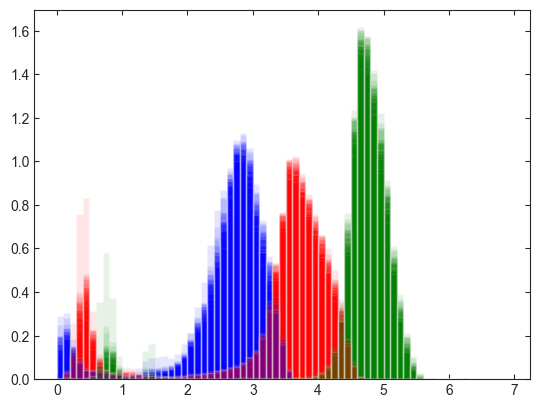

In [6]:
bins = nz.default_nz_bins()

for n in range(nzs.shape[0]):
    hist = plt.hist(nzs[n][0], density=True, bins=bins, alpha = 0.1, color='blue')
    hist = plt.hist(nzs[n][1], density=True, bins=bins, alpha = 0.1, color='red')
    hist = plt.hist(nzs[n][2], density=True, bins=bins, alpha = 0.1, color='green')

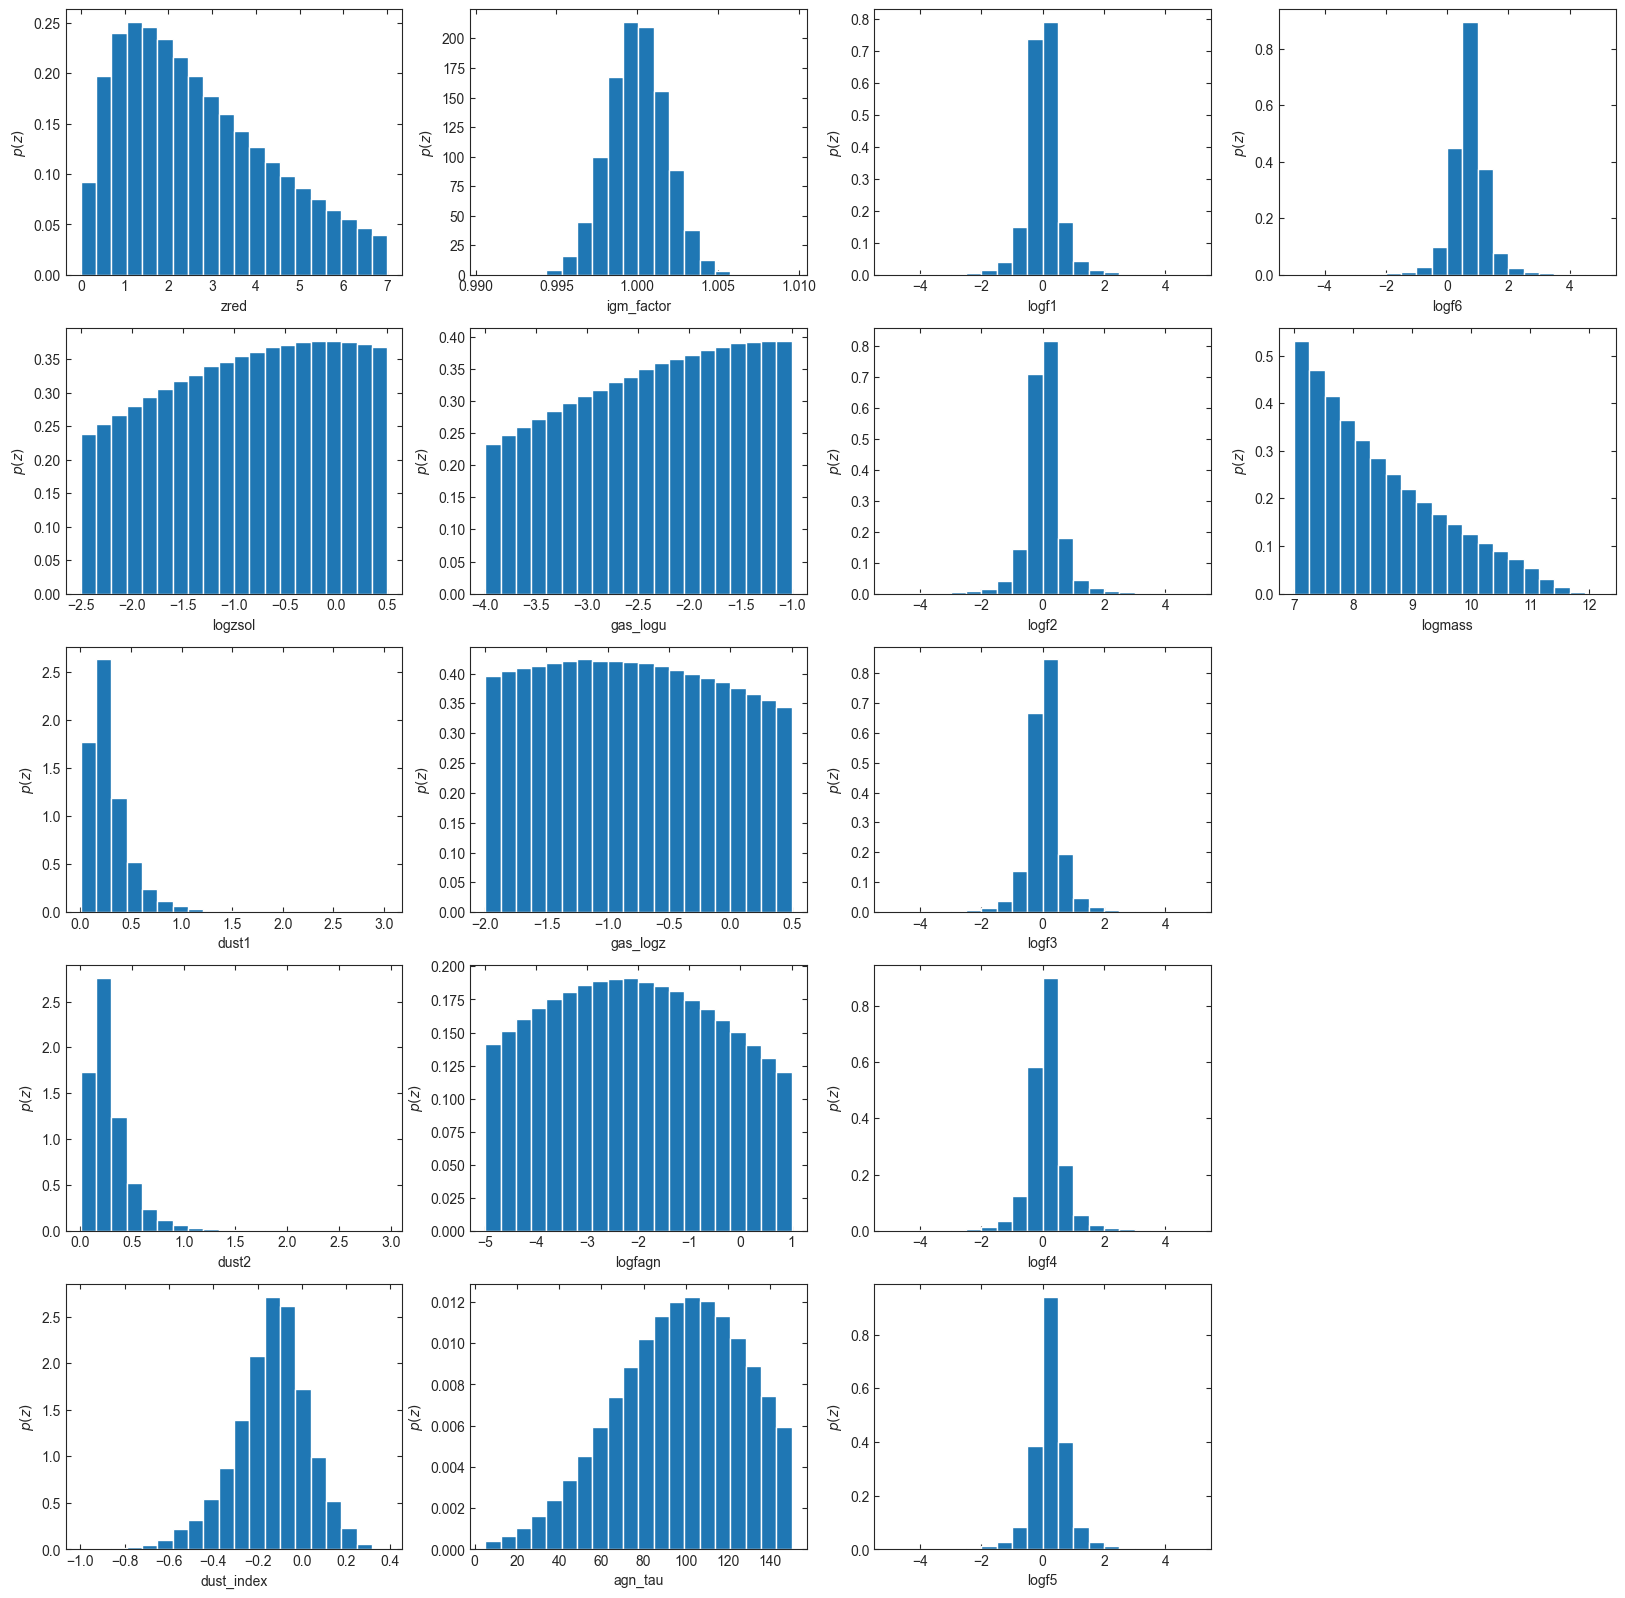

In [7]:
indx=np.random.randint(0, nzs.shape[0])
pop.plot_galaxy_population(spsp[indx])

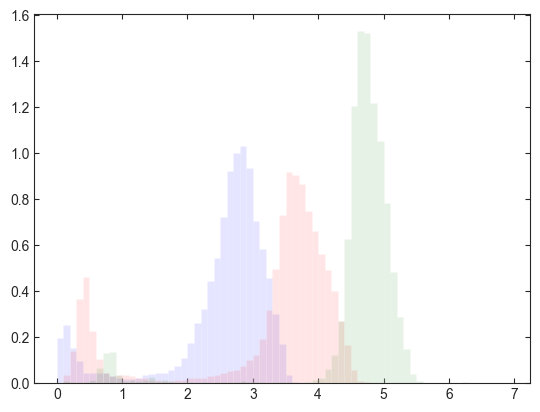

In [30]:
indx=np.random.randint(0, nzs.shape[0])
hist = plt.hist(nzs[indx][0], density=True, bins=bins, alpha = 0.1, color='blue')
hist = plt.hist(nzs[indx][1], density=True, bins=bins, alpha = 0.1, color='red')
hist = plt.hist(nzs[indx][2], density=True, bins=bins, alpha = 0.1, color='green')

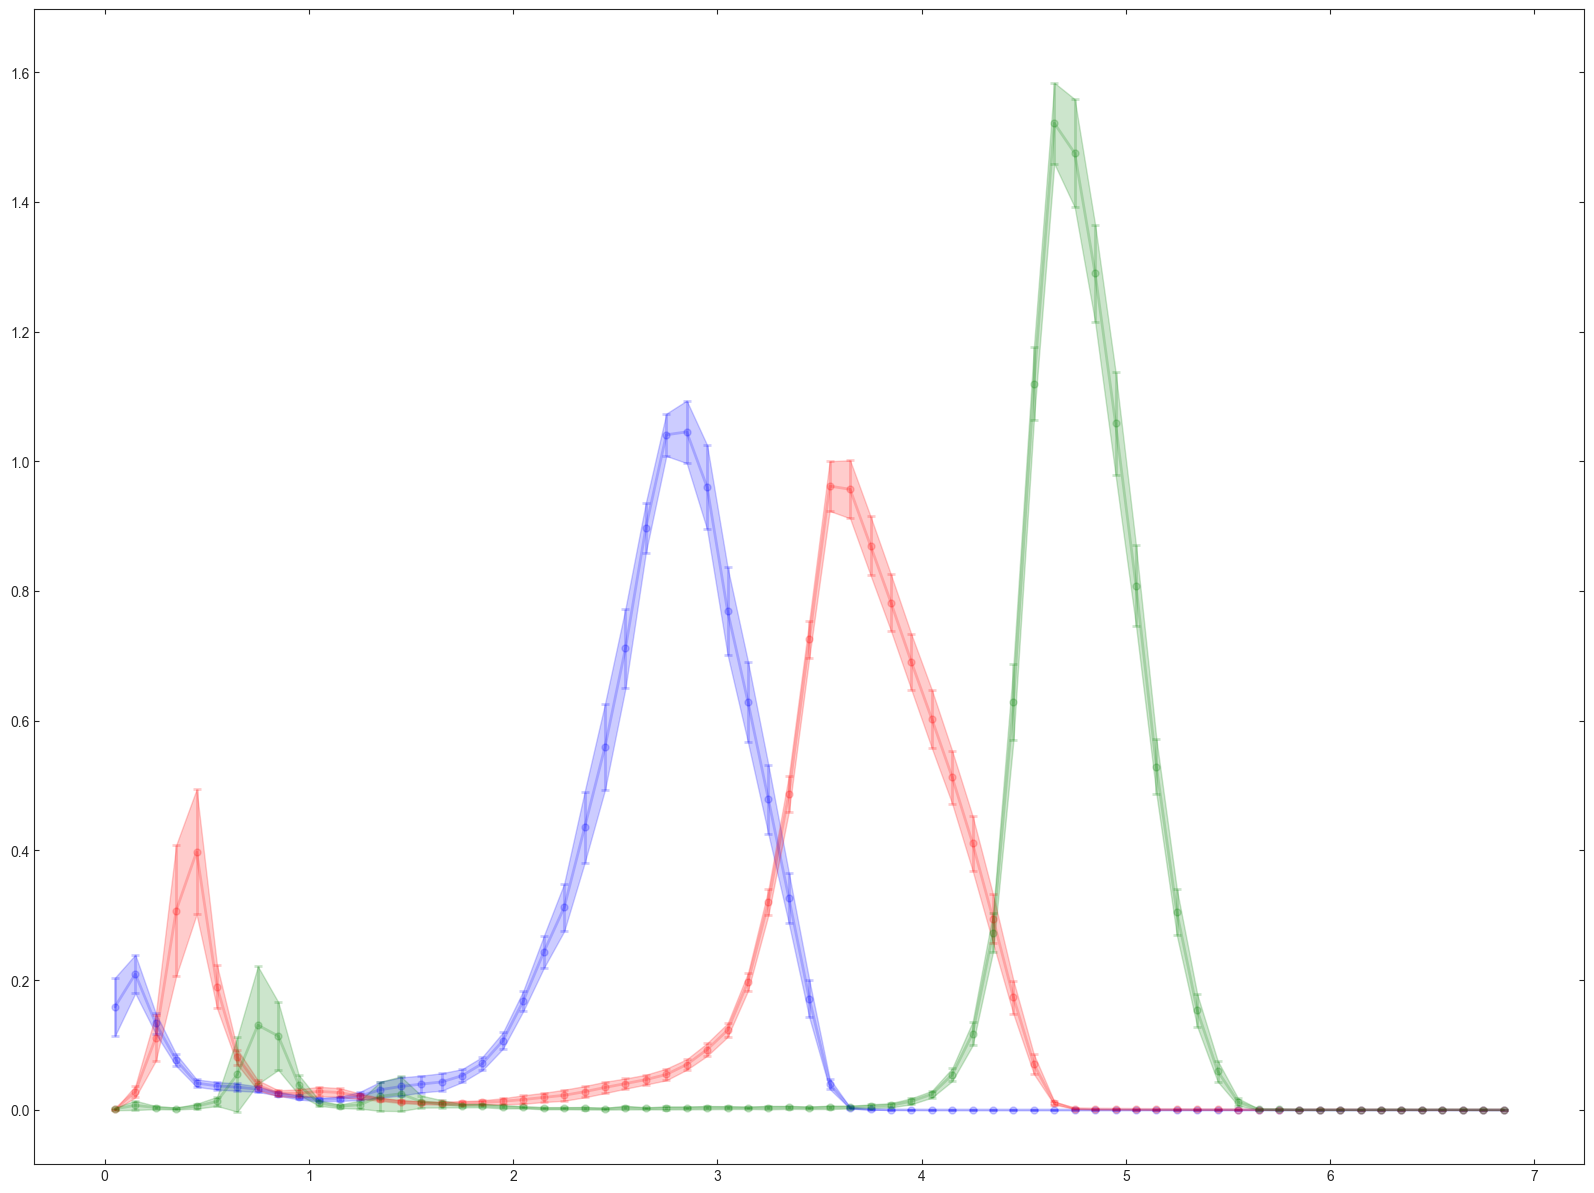

In [9]:
fig1, axes = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

colours = ['blue', 'red', 'green']
for drop in range(3):

    values = []
    x = []
    for n in range(nzs.shape[0]):
        hist = axes.hist(nzs[n][drop], density=True, bins=bins, alpha = 0.001, color=colours[drop])
        values.append(hist[0])
        x.append(hist[1])

    values = np.hstack((np.array(values)))
    x = np.array(x)
    x = np.hstack(((x+0.05)[:,:-1]))


    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'mean', bins=bins)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'std', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes.errorbar(bin_centers, bin_means, bin_std, alpha=0.2, ms=10, marker=".", elinewidth=2, capsize=3, capthick=2, lw=2, color=colours[drop])
    axes.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2, color=colours[drop])

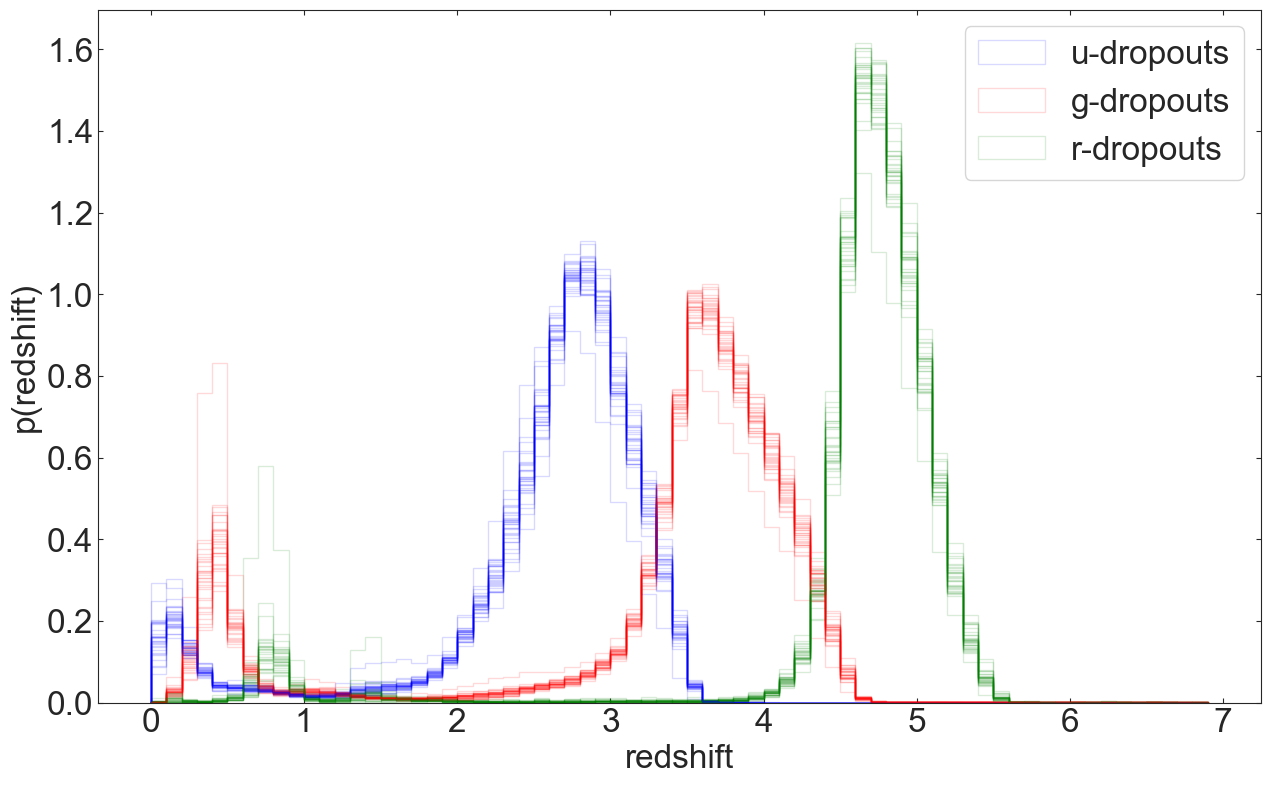

In [10]:
colours = ['blue', 'red', 'green']
labels = ['u-dropouts', "g-dropouts", "r-dropouts"]
ndropouts=3
f, ax = plt.subplots(1, 1, figsize=(15, 9))
for ind in range(nzs.shape[0]):
    for drop in range(ndropouts):
        if(ind == 0):
            hist = plt.hist(nzs[ind][drop], density=True, bins=nz.default_nz_bins(), alpha = 0.15, color=colours[drop], histtype='step', label=labels[drop])
        else:
            hist = plt.hist(nzs[ind][drop], density=True, bins=nz.default_nz_bins(), alpha = 0.15, color=colours[drop], histtype='step')
plt.legend(fontsize=24)
plt.xlabel("redshift", fontsize=24)
plt.ylabel("p(redshift)", fontsize=24)
plt.tick_params('x', labelsize=24)
plt.tick_params('y', labelsize=24)

(0.0, 2.5)

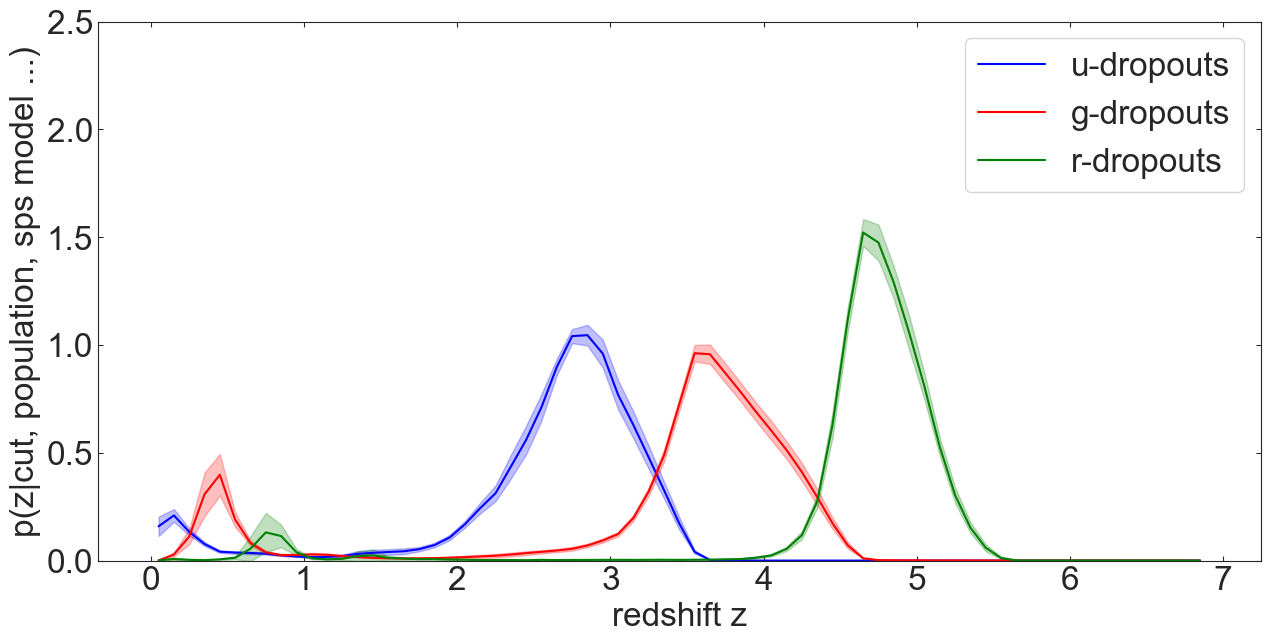

In [11]:
fig1, axes = plt.subplots(1, 1, figsize=(15,7), sharex=False, sharey=False)

for drop in range(ndropouts):

    values = []
    x = []
    for ind in range(nzs.shape[0]):
        hist = axes.hist(nzs[ind][drop], density=True, bins=nz.default_nz_bins(), alpha = 0.001, color=colours[drop])
        values.append(hist[0])
        x.append(hist[1])

    values = np.hstack((np.array(values)))
    x = np.array(x)
    x = np.hstack(((x+0.05)[:,:-1]))


    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'mean', bins=nz.default_nz_bins())
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'std', bins=nz.default_nz_bins())
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    #axes.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=10, fmt="o", elinewidth=2, capsize=3, capthick=2, lw=2, color=colours[drop], label=labels[drop])
    axes.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.25, color=colours[drop])
    axes.plot(bin_centers, bin_means, color=colours[drop], label=labels[drop])

plt.legend(fontsize=24)
plt.xlabel("redshift z", fontsize=24)
plt.ylabel("p(z|cut, population, sps model ...)", fontsize=24)
plt.tick_params('x', labelsize=24)
plt.tick_params('y', labelsize=24)
plt.ylim(0, 2.5)

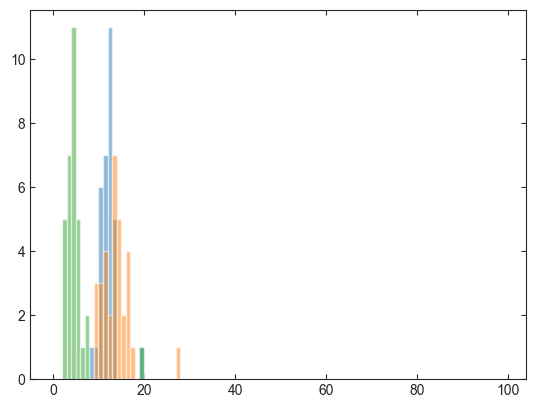

In [12]:
def interlopers(samples):
    nint = len(np.where(samples<2.0)[0])
    ntot = len(samples)
    return (nint/ntot)*100

uints = []
gints = []
rints = []
for n in range(nzs.shape[0]):
    uints.append(interlopers(nzs[n][0]))
    gints.append(interlopers(nzs[n][1]))
    rints.append(interlopers(nzs[n][2]))

nbins = np.arange(0.0, 100, 1)
histogram = plt.hist(uints, alpha=0.5, bins=nbins)
histogram = plt.hist(gints, alpha=0.5, bins=nbins)
histogram = plt.hist(rints, alpha=0.5, bins=nbins)

(-12.0, -8.0)

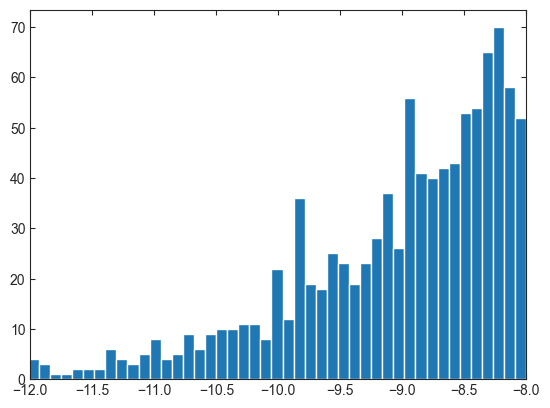

In [13]:
import lbg_forecast.sfh as sfh
indx=np.random.randint(0, nzs.shape[0])
nsample = 1000
recent_sfrs = np.log10(sfh.calculate_recent_sfr(spsp[indx][:nsample, 0], spsp[indx][:nsample, -1], spsp[indx][:nsample, 10:-1])/spsp[indx][:nsample, -1])
plt.hist(recent_sfrs, bins=70)
plt.xlim(-12, -8)

In [14]:
#np.save("redshifts/emulated_redshifts_0.npy", nzs)

In [15]:
#np.save("nzs_test2.npy", nzs)
#np.save("spsp_test2.npy", spsp)